In [1]:
#compression_ratios = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
compression_ratios = [0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6]


def round_to_nearest_ratio(number, ratios=compression_ratios, num_dec_pts=2):
    ratios.sort()
    if number <= ratios[0]:
        return ratios[0]
    if number >= ratios[-1]:
        return ratios[-1]

    for i in range(len(ratios) - 1):
        if ratios[i] < number <= ratios[i + 1]:
            val_1 = round(number - ratios[i], num_dec_pts)
            val_2 = round(ratios[i + 1] - number, num_dec_pts)

            if val_1 == val_2:
                return ratios[i + 1]
            else:
                min_val = round(min(val_1, val_2), num_dec_pts)

                if min_val == val_1:
                    return ratios[i]
                elif min_val == val_2:
                    return ratios[i + 1]


In [2]:
degrees = [x for x in range(5)]

In [3]:
%%time
from data_utils import load_ucr_archive, load_ucr_dataset

data = load_ucr_archive()
data.drop(data[data["dataset"] == "ACSF1"].index, inplace=True)

#data = load_ucr_dataset(8)
data.head()

CPU times: total: 859 ms
Wall time: 912 ms


,dataset,num,data
0,BirdChicken,0,"[(0.0, 1.7631034181603629), (0.001956947162426..."
1,BirdChicken,1,"[(0.0, 0.39195604706942583), (0.00195694716242..."
2,BirdChicken,2,"[(0.0, 0.5253543705670022), (0.001956947162426..."
3,BirdChicken,3,"[(0.0, 1.6577223595060477), (0.001956947162426..."
4,BirdChicken,4,"[(0.0, 1.627195935235928), (0.0019569471624266..."


In [4]:
%%time
from spline_utils import generate_knot_vector, generate_knot_counts
from fit import fit_max_spline, fit_max_l1_spline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from spline_utils import evaluate_spline
import pandas as pd

results = []
error_ts = []
for index, row in data.iterrows():
    time_series = row['data']
    print(row['dataset'], "no.", row['num'])
    for degree in degrees:
        counts = generate_knot_counts(num_data_pts=len(time_series), degree=degree, ratios=compression_ratios)
        for count in counts:
            knots = generate_knot_vector(degree=degree, num_knots=count)

            max_dist, result = fit_max_spline(time_series, knots, degree)
            if max_dist is None and result is None:
                error_ts.append({
                    'dataset': row['dataset'],
                    'num': row['num'],
                    'degree': degree,
                    'num_data_pts': len(time_series),
                    'num_knots': count,
                    'compression_rate': round_to_nearest_ratio(count / len(time_series))
                })
                continue

            # calculate error measures
            fitted_spline = [evaluate_spline(knots, result, degree, x[0]) for x in time_series]
            mse = mean_squared_error(fitted_spline, [x[1] for x in time_series])
            mae = mean_absolute_error(fitted_spline, [x[1] for x in time_series])

            results.append({
                'dataset': row['dataset'],
                'num': row['num'],
                'degree': degree,
                'num_data_pts': len(time_series),
                'num_knots': count,
                'compression_rate': round_to_nearest_ratio(count / len(time_series)),
                'max_dist': max_dist,
                'MSE': mse,
                'MAE': mae
            })


BirdChicken no. 0
BirdChicken no. 1


KeyboardInterrupt: 

In [5]:
df = pd.DataFrame(results)
error_df = pd.DataFrame(error_ts)
df

,dataset,num,degree,num_data_pts,num_knots,compression_rate,max_dist,MSE,MAE
0,BirdChicken,0,0,512,5,0.01,1.829967,1.059870,0.881882
1,BirdChicken,0,0,512,10,0.02,1.433626,0.630884,0.663885
2,BirdChicken,0,0,512,15,0.03,0.923816,0.331975,0.502129
3,BirdChicken,0,0,512,25,0.05,0.683616,0.174758,0.358218
4,BirdChicken,0,0,512,51,0.10,0.353761,0.054236,0.205789
...,...,...,...,...,...,...,...,...,...
70,BirdChicken,1,3,512,8,0.02,1.707983,1.434164,1.084556
71,BirdChicken,1,3,512,10,0.02,1.589690,1.159237,0.958087
72,BirdChicken,1,3,512,15,0.03,0.316708,0.035077,0.162418
73,BirdChicken,1,3,512,25,0.05,0.139596,0.007482,0.075498


# PLOTS

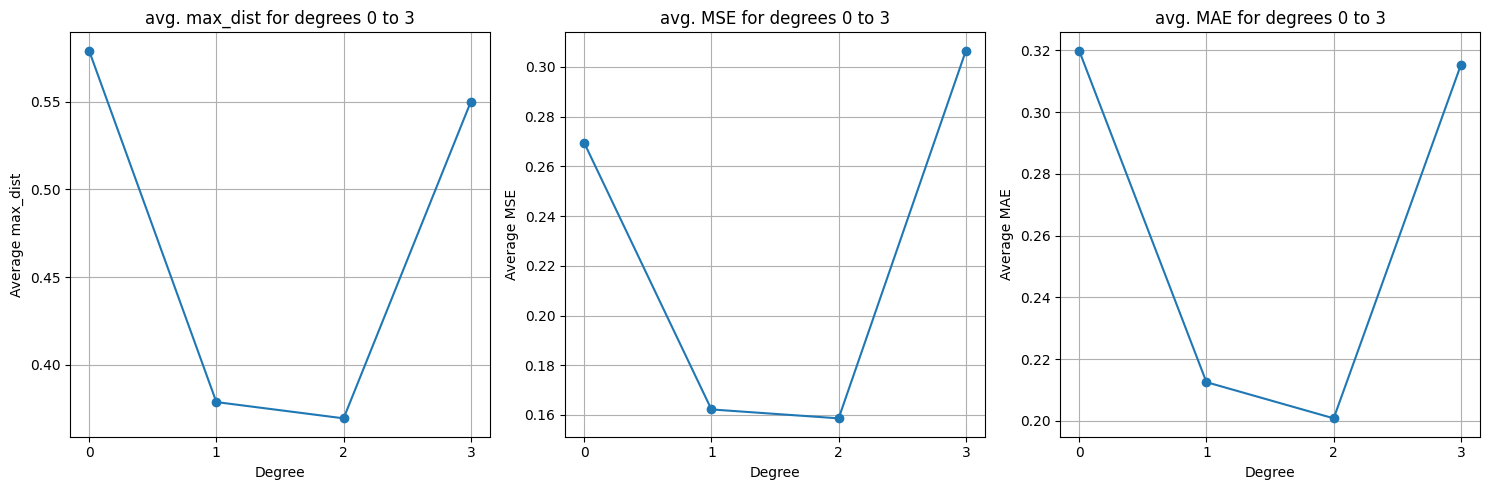

In [6]:
import matplotlib.pyplot as plt

metrics = ['max_dist', 'MSE', 'MAE']
# the same but plotting the graphs next to each other
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    avg_metric_by_degree = df.groupby('degree')[metric].mean()
    axs[i].plot(avg_metric_by_degree.index, avg_metric_by_degree.values, marker='o', linestyle='-')
    axs[i].set_xlabel('Degree')
    axs[i].set_ylabel('Average ' + metric)
    axs[i].set_title('avg. ' + metric + ' for degrees 0 to ' + str(max(df['degree'].unique())))
    axs[i].set_xticks(list(avg_metric_by_degree.index))
    axs[i].grid(True)

plt.tight_layout()
plt.show()

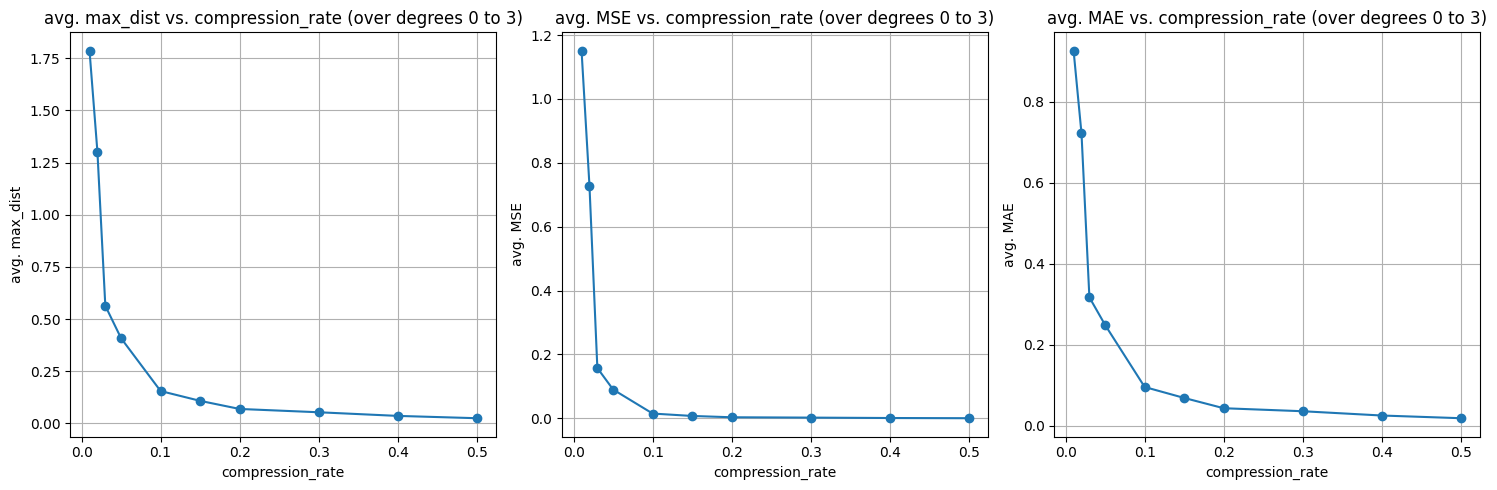

In [7]:
plt.show()
# avg max_dist/mse/mae (accuracy whatever) vs compression rate (avg. over all degrees)
avg_mse_by_compression_rate = df.groupby('compression_rate')['max_dist'].mean()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    avg_mse_by_compression_rate = df.groupby('compression_rate')[metric].mean()
    axs[i].plot(avg_mse_by_compression_rate.index, avg_mse_by_compression_rate.values, marker='o', linestyle='-')
    axs[i].set_xlabel('compression_rate')
    axs[i].set_ylabel('avg. ' + metric)
    axs[i].set_title(
        'avg. ' + metric + ' vs. compression_rate (over degrees 0 to ' + str(max(df['degree'].unique())) + ')')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

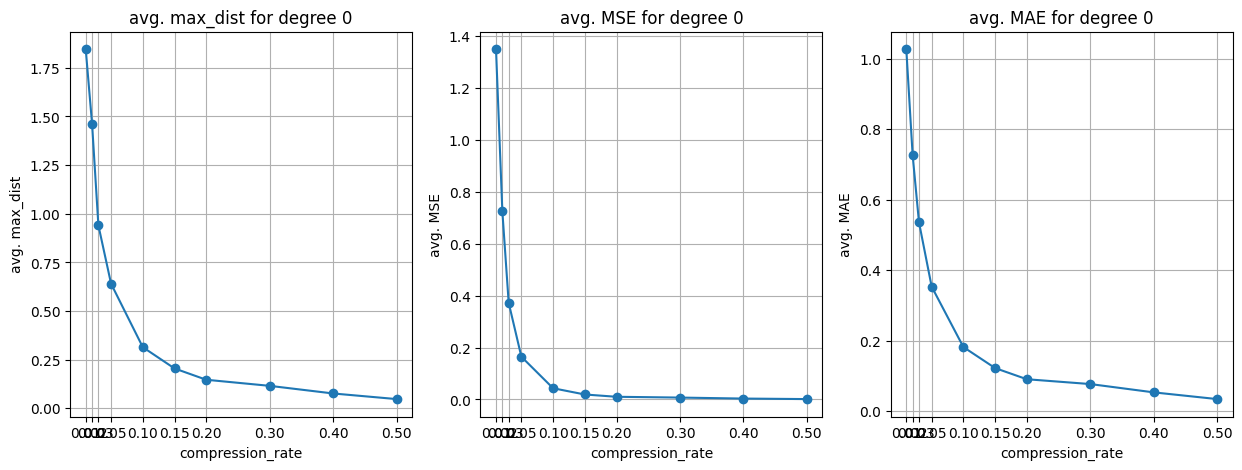

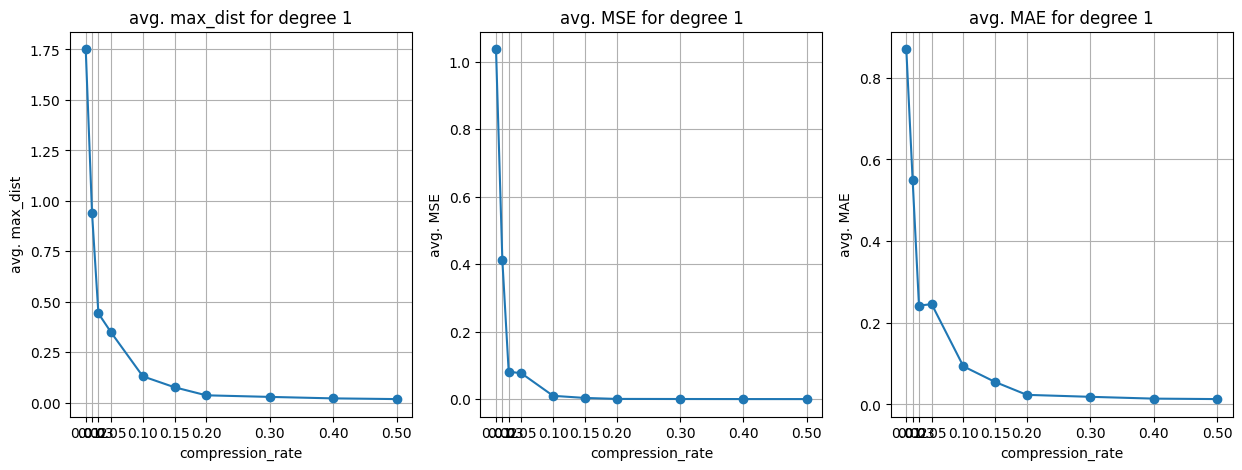

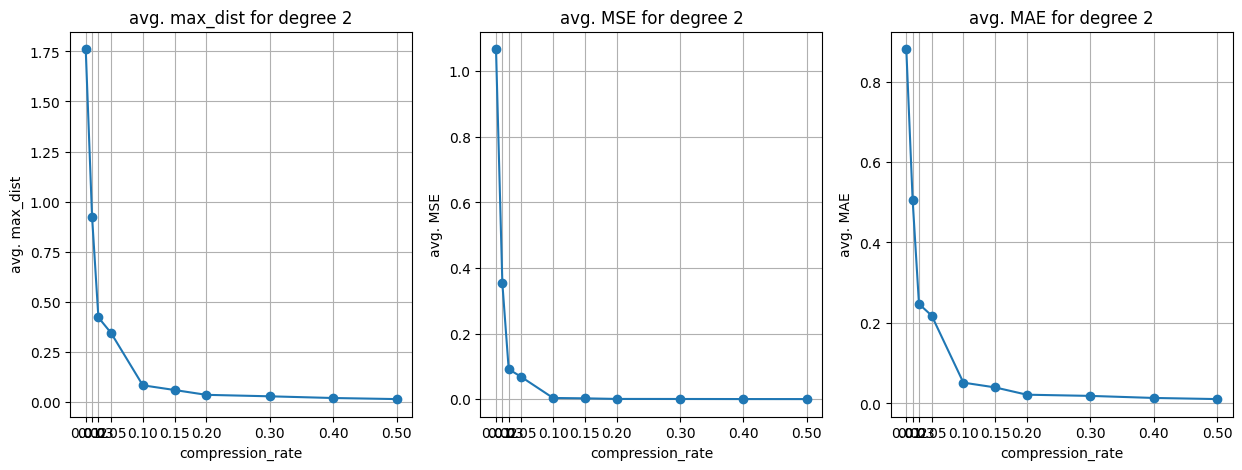

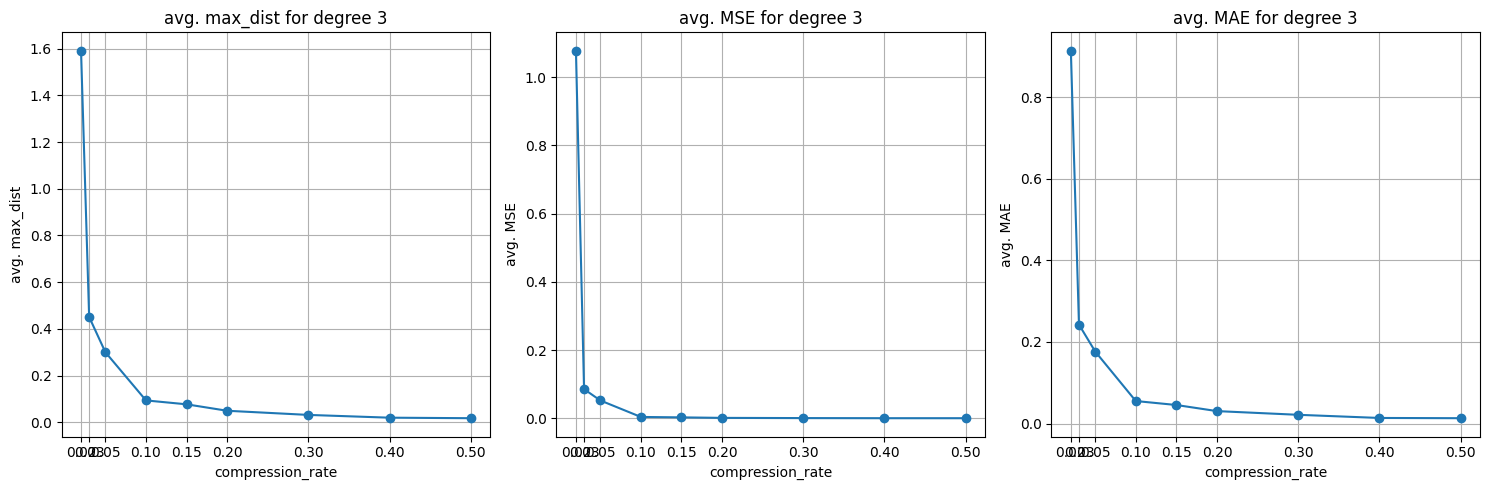

In [8]:
# compression rate vs. avg. accuracy metrics (for each degree)
for degree, group in df.groupby('degree'):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    sub_df = df[df['degree'] == degree]
    for i, metric in enumerate(metrics):
        avg_metric_by_compression = sub_df.groupby('compression_rate')[metric].mean()
        print()
        #x= df.groupby('degree')[metric].mean()
        axs[i].plot(avg_metric_by_compression.index, avg_metric_by_compression.values, marker='o', linestyle='-')
        axs[i].set_xlabel('compression_rate')
        axs[i].set_ylabel('avg. ' + metric)
        axs[i].set_title('avg. ' + metric + ' for degree ' + str(degree))
        axs[i].set_xticks(list(avg_metric_by_compression.index))
        axs[i].grid(True)

plt.tight_layout()
plt.show()